## 02. Cross correlation to determine redshift;
This notebook aims at getting redshift of an object with multiple emission lines, by using Specutils template correlation.

- This notebook starts with optimally extracted 1D spectra, from notebook No.1.
- Target is a galaxy with multiple emission lines falling in NIRISS WFSS spectrum. Those w/o emission lines (e.g., ID 00003 in the previous notebook) may fail with the function here, and we refer the user to look at Notebook no.04, using absorption lines and direct images to get redshift.

In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import h5py

from astropy.convolution import Gaussian2DKernel
from astropy.io import fits
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.table import QTable
from astropy.table import Table
import astropy.units as u
from astropy.visualization import make_lupton_rgb, SqrtStretch, ImageNormalize, simple_norm
import astropy.wcs as wcs
from astropy.io import ascii
from astropy.nddata import StdDevUncertainty
from astropy.modeling.polynomial import Chebyshev1D
from astropy import constants as const
from astropy.io.misc import hdf5

import astropy
print('astropy', astropy.__version__)


astropy 4.0.1.post1


In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

In [4]:
import specutils
from specutils.fitting import continuum 
from specutils.spectra.spectrum1d import Spectrum1D
from specutils.analysis import correlation
from specutils.spectra.spectral_region import SpectralRegion

print("Specutils: ", specutils.__version__)

Specutils:  1.0


### 0. Download notebook 01 products
These can be also obtained by running the notebooks.

In [7]:
if not os.path.exists('./output'):
    import zipfile
    import urllib.request
    boxlink = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/NIRISS_lensing_cluster/output.zip'
    boxfile = './output.zip'
    urllib.request.urlretrieve(boxlink, boxfile)
    zf = zipfile.ZipFile(boxfile, 'r')
    zf.extractall()
else:
    print('Already exists')

### 1.Open optimally extracted 1D spectrum text file;
These are optimally extracted, normalized spectra from notebooks 01a & 01b.

In [8]:
DIR_OUT = './output/'
filt = 'f200w'

grism = 'G150C'
#grism = 'G150R'

id = '00004'

file_1d = '%sl3_nis_%s_%s_s%s_combine_1d_opt.fits'%(DIR_OUT, filt, grism, id)
fd = fits.open(file_1d)[1].data
hd = fits.open(file_1d)[1].header
fd

FITS_rec([(1.71986127, 42.38365482, 1.51015508),
          (1.72453201, 38.56917716, 0.97178267),
          (1.72920275, 35.93947653, 0.62354777),
          (1.73387337, 23.77350774, 0.31776521),
          (1.73854411, 22.91664629, 0.21997059),
          (1.74321485, 18.82889931, 0.14420642),
          (1.74788558, 16.24401145, 0.10209115),
          (1.7525562 , 12.60893081, 0.0719594 ),
          (1.75722694, 10.30048011, 0.05026028),
          (1.76189768, 10.56057566, 0.04827347),
          (1.76656842, 10.80664315, 0.04615251),
          (1.77123904, 10.96807816, 0.04635962),
          (1.77590978, 10.84610055, 0.04520876),
          (1.78058052, 11.14885447, 0.04861023),
          (1.78525114, 11.40215898, 0.05138483),
          (1.78992188, 11.48868052, 0.04729241),
          (1.79459262, 11.58795191, 0.04634937),
          (1.79926336, 11.73206527, 0.04663301),
          (1.80393398, 11.97186637, 0.04839924),
          (1.80860472, 11.9611019 , 0.04914871),
          (1.8132754

In [9]:
# Normalization of observed spectra; Just for visual purpose;
flux_normalize = 500.

In [10]:
wave_200 = fd['wavelength']
flux_200 = fd['flux'] / flux_normalize
flux_err_200 = fd['uncertainty'] / flux_normalize

In [11]:
# Open files for other filters.
filt = 'f150w'
file_1d = '%sl3_nis_%s_%s_s%s_combine_1d_opt.fits'%(DIR_OUT, filt, grism, id)
fd = fits.open(file_1d)[1].data

wave_150 = fd['wavelength']
flux_150 = fd['flux'] / flux_normalize
flux_err_150 = fd['uncertainty'] / flux_normalize

# 
filt = 'f115w'
file_1d = '%sl3_nis_%s_%s_s%s_combine_1d_opt.fits'%(DIR_OUT, filt, grism, id)
fd = fits.open(file_1d)[1].data

wave_115 = fd['wavelength']
flux_115 = fd['flux'] / flux_normalize
flux_err_115 = fd['uncertainty'] / flux_normalize


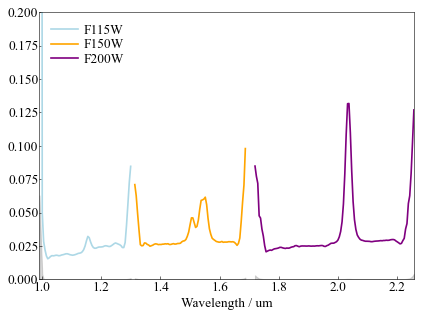

In [12]:
# plot all
plt.figure()
plt.errorbar(wave_115, flux_115, ls='-', color='lightblue', label='F115W')
plt.errorbar(wave_150, flux_150, ls='-', color='orange', label='F150W')
plt.errorbar(wave_200, flux_200, ls='-', color='purple', label='F200W')

plt.fill_between(wave_115, -flux_err_115, flux_err_115, ls='-', color='gray', label='', alpha=0.3)
plt.fill_between(wave_150, -flux_err_150, flux_err_150, ls='-', color='gray', label='', alpha=0.3)
plt.fill_between(wave_200, -flux_err_200, flux_err_200, ls='-', color='gray', label='', alpha=0.3)

plt.xlabel('Wavelength / um')
plt.ylim(0., 0.2)
plt.legend(loc=2)

### Continuum is visible. We need to subtract it before template correlation.
- Strong emission lines are seen. (Hb+Oiii doublet at ~1.55um, and blended Ha+Nii at ~2.1um)
- Note that flux excess at the edges of each filter are not real, and should be masked out.

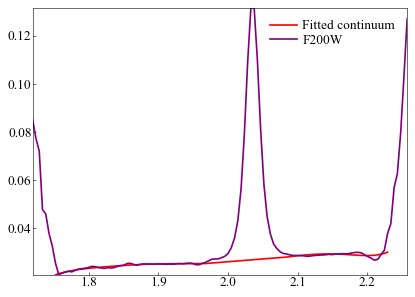

In [14]:
# F200W

spec_unit = u.MJy

mask = ((wave_200 > 1.75) & (wave_200 < 1.97)) | ((wave_200 > 2.08) & (wave_200 < 2.23))

obs_200 = Spectrum1D(spectral_axis=wave_200[mask]*u.um, flux=flux_200[mask]*spec_unit)
continuum_200 = continuum.fit_generic_continuum(obs_200, model=Chebyshev1D(7))

plt.figure()
plt.errorbar(wave_200, flux_200, ls='-', color='purple', label='F200W')
plt.plot(wave_200[mask], continuum_200(obs_200.spectral_axis),color='r',label='Fitted continuum')
plt.legend(loc=0)

flux_200_sub = flux_200 * spec_unit - continuum_200(wave_200*u.um)

mask_200 = (wave_200 > 1.75) & (wave_200 < 2.23)

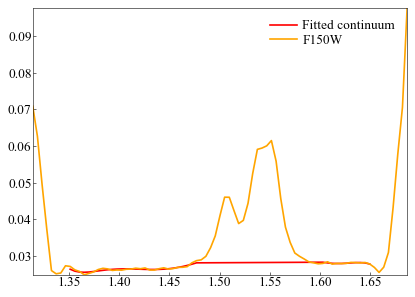

In [15]:
# F150W

spec_unit = u.MJy

mask = ((wave_150 > 1.35) & (wave_150 < 1.48)) | ((wave_150 > 1.6) & (wave_150 < 1.65))

obs_150 = Spectrum1D(spectral_axis=wave_150[mask]*u.um, flux=flux_150[mask]*spec_unit)
continuum_150 = continuum.fit_generic_continuum(obs_150, model=Chebyshev1D(7))

flux_150_sub = flux_150 * spec_unit - continuum_150(wave_150 * u.um)

plt.figure()
plt.errorbar(wave_150, flux_150, ls='-', color='orange', label='F150W')
plt.plot(wave_150[mask], continuum_150(obs_150.spectral_axis), color='r', label='Fitted continuum')
plt.legend(loc=0)

mask_150 = (wave_150 > 1.35) & (wave_150 < 1.65)

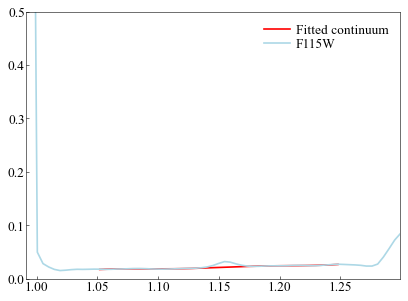

In [16]:
# F150W

spec_unit = u.MJy

mask = ((wave_115 > 1.05) & (wave_115 < 1.13)) | ((wave_115 > 1.17) & (wave_115 < 1.25))

obs_115 = Spectrum1D(spectral_axis=wave_115[mask]*u.um, flux=flux_115[mask]*spec_unit)
continuum_115 = continuum.fit_generic_continuum(obs_115, model=Chebyshev1D(7))

plt.figure()
plt.errorbar(wave_115, flux_115, ls='-', color='lightblue', label='F115W')
plt.plot(wave_115[mask], continuum_115(obs_115.spectral_axis), color='r', label='Fitted continuum')
plt.ylim(0, 0.5)
plt.legend(loc=0)

flux_115_sub = flux_115 * spec_unit - continuum_115(wave_115 * u.um)
mask_115 = (wave_115 > 1.02)  & (wave_115 < 1.25)

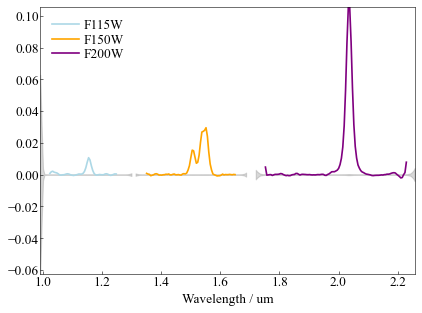

In [17]:
# plot all
plt.figure()
plt.errorbar(wave_115[mask_115], flux_115_sub[mask_115], ls='-', color='lightblue', label='F115W')
plt.errorbar(wave_150[mask_150], flux_150_sub[mask_150], ls='-', color='orange', label='F150W')
plt.errorbar(wave_200[mask_200], flux_200_sub[mask_200], ls='-', color='purple', label='F200W')

plt.fill_between(wave_115, -flux_err_115, flux_err_115,ls='-', color='gray', label='', alpha=0.3)
plt.fill_between(wave_150, -flux_err_150, flux_err_150,ls='-', color='gray', label='', alpha=0.3)
plt.fill_between(wave_200, -flux_err_200, flux_err_200,ls='-', color='gray', label='', alpha=0.3)

plt.xlabel('Wavelength / um')
plt.legend(loc=2)

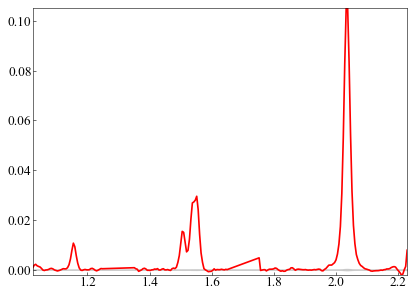

In [18]:
# Concatenate arrays
wave_obs = np.concatenate([wave_115[mask_115], wave_150[mask_150], wave_200[mask_200]])
flux_obs = np.concatenate([flux_115_sub[mask_115], flux_150_sub[mask_150], flux_200_sub[mask_200]])
flux_err_obs = np.concatenate([flux_err_115[mask_115], flux_err_150[mask_150], flux_err_200[mask_200]])

plt.figure()
plt.plot(wave_obs, flux_obs)
plt.fill_between(wave_obs, -flux_err_obs, flux_err_obs, ls='-', color='gray', label='', alpha=0.3)

In [19]:
wht_obs = 1 / flux_err_obs**2
spec_unit = u.MJy

dataspec = QTable([wave_obs*u.um, flux_obs*spec_unit, wht_obs, flux_err_obs],
                   names=('wavelength','flux','weight','uncertainty'))
dataspec_sub = dataspec[dataspec['weight'] > 0.]

# Now make it into a Spectrum1D instance.
p_obs = Spectrum1D(spectral_axis=dataspec_sub['wavelength'],
                 flux=dataspec_sub['flux'],
                 uncertainty=StdDevUncertainty(dataspec_sub['uncertainty']), unit='MJy')

### Do cross-correlation with an input template;
(*Another notebook on Specutils cross correlation by Ivo Busko: https://spacetelescope.github.io/jdat_notebooks/pages/redshift_crosscorr/redshift_crosscorr.html)

### Load synthetic template;
- Just to test the functionality, for now we are using the input spectral template used for simulation.

In [20]:
def read_hdf5(filename):

    contents = {}
    with h5py.File(filename, 'r') as file_obj:
        no_wave_units = False
        no_flux_units = False
        for key in file_obj.keys():
            dataset = file_obj[key]
            try:
                wave_units_string = dataset.attrs['wavelength_units']
            except KeyError:
                wave_units_string = 'micron'
                no_wave_units = True
            try:
                flux_units_string = dataset.attrs['flux_units']
            except KeyError:
                flux_units_string = 'flam_cgs'
                no_flux_units = True

            # Catch common errors
            if wave_units_string.lower() in ['microns', 'angstroms', 'nanometers']:
                wave_units_string = wave_units_string[0:-1]

            # Get the data
            waves = dataset[0]
            fluxes = dataset[1]

            contents[int(key)] = {'wavelengths': waves, 'fluxes': fluxes}

    return contents

In [21]:
# Download files, if not exists yet.
if not os.path.exists('./pipeline_products'):
    import zipfile
    import urllib.request
    boxlink = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/NIRISS_lensing_cluster/pipeline_products.zip'
    boxfile = './pipeline_products.zip'
    urllib.request.urlretrieve(boxlink, boxfile)
    zf = zipfile.ZipFile(boxfile, 'r')
    zf.extractall()

In [22]:
# Template file;
file_temp = './pipeline_products/source_sed_file_from_sources_extend_01_and_sed_file.hdf5'

content = read_hdf5(file_temp)
content

{10177: {'wavelengths': array([3.0999999e-02, 3.1072199e-02, 3.1144397e-02, ..., 3.4099831e+01,
         3.4099903e+01, 3.4099976e+01], dtype=float32),
  'fluxes': array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.4608030e-25,
         8.3700207e-26, 2.1320117e-26], dtype=float32)},
 10265: {'wavelengths': array([3.0999999e-02, 3.1072199e-02, 3.1144397e-02, ..., 3.4099831e+01,
         3.4099903e+01, 3.4099976e+01], dtype=float32),
  'fluxes': array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.7282180e-25,
         9.9022388e-26, 2.5222983e-26], dtype=float32)},
 10455: {'wavelengths': array([3.0999999e-02, 3.1072199e-02, 3.1144397e-02, ..., 3.4099831e+01,
         3.4099903e+01, 3.4099976e+01], dtype=float32),
  'fluxes': array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.4816426e-26,
         8.4894260e-27, 2.1624266e-27], dtype=float32)},
 10709: {'wavelengths': array([3.0999999e-02, 3.1072199e-02, 3.1144397e-02, ..., 3.4099831e+01,
         3.4099903e+01, 3

(2000.0, 8000.0)

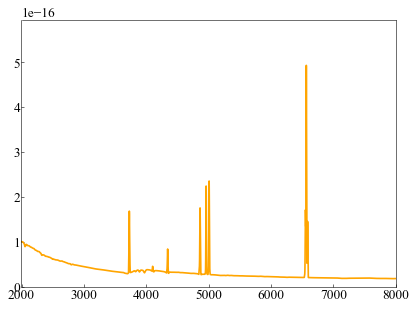

In [23]:
# The template is already redshifted for simulation. 
# Now, blueshift it to z=0;
z_input  = 2.1 
iix = 10709 # Index for the particular template.

flux_all = content[iix]['fluxes']
wave_all = content[iix]['wavelengths'] / (1. + z_input) * 1e4
plt.plot(wave_all, flux_all, color='orange')
plt.xlim(2000,8000)

Text(0.5, 0, 'um')

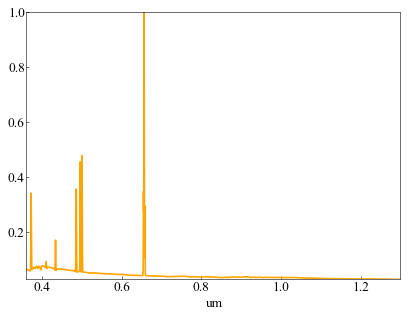

In [25]:
# Cut templates for better fit.
con_tmp = (wave_all > 3600) & (wave_all < 13000)
flux = flux_all[con_tmp]
wave = wave_all[con_tmp]
flux /= flux.max()

wave *= 1.e-4 # force wavelengths in um. (with_spectral_unit doesn't convert)

factor = p_obs.flux.unit # normalize template to a sensible range
template = Spectrum1D(spectral_axis=wave*u.um, flux=flux*factor)

plt.figure()
plt.plot(template.spectral_axis, template.flux, color='orange')
plt.xlabel(template.spectral_axis.unit)

### Binning the template into a course array, if you have too many elements and cause an issue below;
### -> In this example this is not necessary.

Text(0.5, 0, 'um')

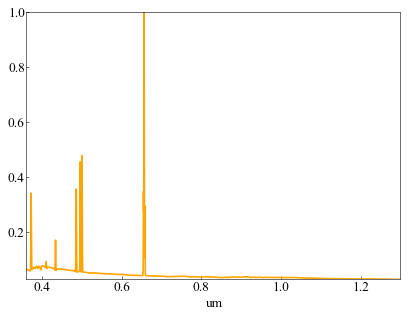

In [33]:
# Make this true, if you want to bin;
if False:
    wave_bin = np.arange(wave.min(), wave.max(), 20.0)
    flux_bin = np.interp(wave_bin, wave, flux)
else:
    wave_bin = wave
    flux_bin = flux

factor = p_obs.flux.unit # normalize template to a sensible range
template = Spectrum1D(spectral_axis=wave_bin*u.um, flux=flux_bin*factor)

plt.figure()    
plt.plot(template.spectral_axis, template.flux, color='orange')
plt.xlabel(template.spectral_axis.unit)

Text(0.5, 1.0, 'Continuum subtracted template')

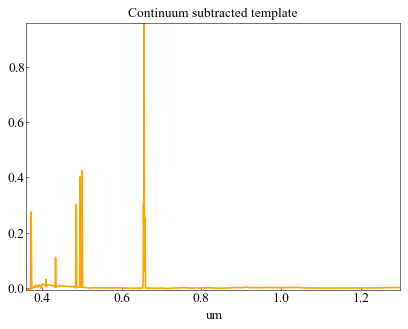

In [34]:
# Continuum fit to the fitting temp;
regions = [SpectralRegion(0.37*u.um, 0.452*u.um), 
           SpectralRegion(0.476*u.um, 0.53*u.um),
           SpectralRegion(0.645*u.um, 0.67*u.um)]

continuum_model = continuum.fit_generic_continuum(template, model=Chebyshev1D(3), exclude_regions=regions)

p_template = template - continuum_model(template.spectral_axis)

plt.figure()
plt.plot(p_template.spectral_axis, p_template.flux, color='orange')
plt.xlabel(p_template.spectral_axis.unit)
plt.title('Continuum subtracted template')

In [35]:
# Put data array into Specutils format;
sflux = p_template.flux 
p_smooth_template = Spectrum1D(spectral_axis=p_template.spectral_axis,
                               flux=sflux/sflux.max())


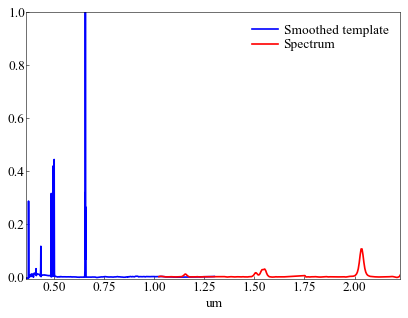

In [36]:
plt.figure()
plt.plot(p_smooth_template.spectral_axis, p_smooth_template.flux, color='b', label='Smoothed template')
plt.plot(p_obs.spectral_axis, p_obs.flux, color='red', label='Spectrum')
plt.xlabel(p_smooth_template.spectral_axis.unit)
plt.legend(loc=0)

#### CAUTION: Two inputs spectra above have to overlap, if only a small part, to make Specutils works properly.

### Cross Correlation using specutils functionarity; 

In [37]:
### With no additional specifications, both the entire template and entire spectrum 
### will be included in the correlation computation. This in general will incur in 
### a significant increase in execution time. It is advised that the template is cut
### to work only on the useful region.

corr, lag = correlation.template_correlate(p_obs, p_smooth_template)

/Users/tmorishita/anaconda3/envs/jwst_env_016/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Text(0.5, 0, 'km / s')

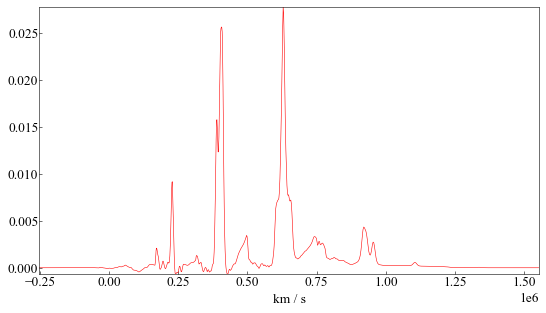

In [38]:
plt.figure()
plt.gcf().set_size_inches((8., 4.))
plt.plot(lag, corr, linewidth=0.5)
plt.xlabel(lag.unit)

In [39]:
# Redshift based on maximum
index_peak = np.argmax(corr)

v = lag[index_peak]

z = v / const.c.to('km/s')
print("Peak maximum at: ", v)
print("Redshift from peak maximum: ", z)

Peak maximum at:  628833.1938062641 km / s
Redshift from peak maximum:  2.0975617532255066


In [40]:
# Redshift based on parabolic fit to mazimum
n = 8 # points to the left or right of correlation maximum
peak_lags = lag[index_peak-n : index_peak+n+1].value
peak_vals = corr[index_peak-n : index_peak+n+1].value
p = np.polyfit(peak_lags, peak_vals, deg=2)
roots = np.roots(p)

v_fit = np.mean(roots) * u.km/u.s # maximum lies at mid point between roots
z = v_fit / const.c.to('km/s')

print("")
print("Parabolic fit with maximum at: ", v_fit)
print("Redshift from parabolic fit: ", z)


Parabolic fit with maximum at:  629196.3189064465 km / s
Redshift from parabolic fit:  2.0987730081803675


### How does it look?

z = 2.0987730081803675


Text(0.5, 0, 'um')

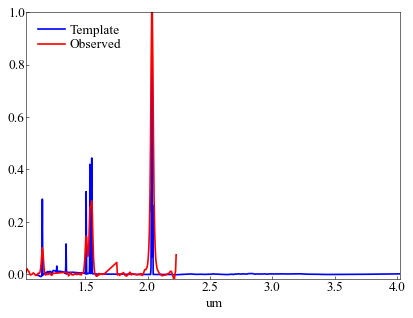

In [43]:
print('z =',z)
plt.figure()

plt.plot(
    template.spectral_axis * (1. + z), 
    p_smooth_template.flux / np.max(p_smooth_template.flux), 
    color='b', label='Template'
)

plt.plot(p_obs.spectral_axis, p_obs.flux / np.max(p_obs.flux), label='Observed')
plt.legend(loc=2)
plt.xlabel(p_obs.spectral_axis.unit)